앙상블(Ensemble)  

앙상블 기법이란 여러개의 분류 모델을 조합해서 더 나은 성능을 얻어내는 방법이다.  
최근접 이웃, 서포트 백터 머신, 의사 결정 트리, 나이브 베이즈 분류 모델을 실습했는데 지금까지 실습한 여러 분류 모델을 조합해서 단일 모델보다 더 좋은 성능을 낸다.  

배깅(Bagging)  

배깅은 부트스트랩(bootstarp)과 어그리게이팅(aggregating, 집계)에서 왔고 상당히 연주하기 힘든 바이올린 연주곡을 2,3명의 초급 바이올린 연주자가 나누어 연주함으로써  
한 명의 중급 바이올린 연주자가 연주하는 것보다 더 나은 연주를 할 수 있는 것과 유사하다.  
(여기서 부트스트랩은 css의 부트스트랩과 다르다.)  
중급 바이올린 연주자는 나름 잘 학습했지만 학습 데이터에 과대 적합된 의사 결정 트리라 볼 수 있다.  
의사결정 트리의 단점은 쉽게 과대 적합된다는 것인데 배경은 과대적합이 쉬운 모델에 상당히 적합한 앙상블이다.  

배경은 한 가지 분류 모델을 여러 개 만들어서 서로 다른 학습 데이터로 학습시킨 후(부트스트랩), 동일한 테스트 데이터에 대한 서로 다른 예측값들을 투표를 통해(어그리게이팅)  
가장 높은 예측값으로 최종 결론을 내리는   
하드보팅: 대선선거 / 소프트보팅: 주주총회  

<img src="./images/1.png" align="left" width="700">
<img src="./images/2.png" align="left" width="700">
<img src="./images/3.png" align="left" width="700">

<랜덤 포레스트>(Random Forest)  

여러 의사 결정 트리를 배깅을 적용해서 예측을 실행하는 모델이다.  
배깅은 모든 분류 모델에서 적용 가능하지만 특히 과대 적합되기 쉬운 의사 결정 트리에 사용하면 확실히 과대 적합을 줄여서 성능이 높아지는 혜택을 보기 때문에  
배깅은 많은 의사 결정 트리 모델의 개선을 이뤘고 여러 개의 나무들이 모여 있다는 개념에서 랜덤 포레스트라는 이름이 생겨났다.  

의사 결정 트리에서 최적의 특징으로 트리를 분기하는 반면 랜덤 포레스트는 각 노드에 주어진 데이터를 샘플링해서 일부 데이터를 제외한채 최적의 특징을 찾아 트리를 분기한다.  
이러한 과정에서 랜덤 포레스트는 또 한 번 모델의 편향을 증가시켜 과대 적합의 위험을 감소시킨다.  

<부스팅>(Boosting)  

여러 개의 분류기를 만들어 투표를 통해 예측값을 결정한다는 측면에서 배깅과 동일하다.  
배깅은 서로 다른 알고리즘에 기반한 여러 분류기를 병렬적으로 학습하는 반면에  
부스팅은 동일한 알고리즘의 분류기를 순차적으로 학습해서 여러 개의 분류기를 만든 후 테스트할 때 가중 투표를 통해 예측값을 결정한다.  



In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# 사이킷런이 제공하는 MNIST 손글씨 데이터를 불러오기 위해 import한다.
from sklearn.datasets import load_digits
# 교차 검증을 실행하기 위해 import한다.
from sklearn.model_selection import cross_val_score
# 사이킷런의 의사 결정 트리를 사용하기 위해 import한다.
from sklearn.tree import DecisionTreeClassifier
# 사이킷런의 랜덤 포레스트를 사용하기 위해 import한다.
from sklearn.ensemble import RandomForestClassifier

MNIST 손글씨 데이터셋으로 랜덤 포레스트 모델과 의사 결정 트리 모델을 동일하게 학습시켜 두 모델의 성능 차이를 시각화해서 비교한다.  

MNIST 손글씨 데이터 불러오기  


In [3]:
mnist = load_digits() # 사이킷런이 제공하는 MNIST 손글씨 데이터를 불러온다.
# print(mnist)
# features = mnist.data
# labels = mnist.target
features, labels = mnist.data, mnist.target
print(features.shape, labels.shape)

(1797, 64) (1797,)


In [4]:
print(type(features[0]))
print(features[0].reshape(8, 8), labels[0])

<class 'numpy.ndarray'>
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]] 0


교차 검증  

cross_val_score(model, X, Y, scoring=None, cv=None)  
model: 분석 모델  
X: 독립 변수, 학습 데이터(피쳐)  
Y: 종속 변수, 학습 결과(실제값, 레이블, 타겟)  
scoring: 성능 검증에 사용할 평가 지표를 지정한다. => 정확도를 의미하는 'accuracy'를 지정한다.  
cv: 교차 검증 생성기 객체 또는 숫자, None이면 KFold(3), 숫자를 지정하면 KFold(숫자)  

MNIST 손글씨 데이터에 대한 의사 결정 트리와 랜덤 포레스트의 검증 정확도를 계산하는 함수

In [5]:
# cross_validation(분류기 모델, 학습 데이터, 학습 데이터에 따른 레이블)
def cross_validation(classifier, features, labels):
    cv_scores = []
    for k in range(10):
        scores = cross_val_score(classifier, features, labels, scoring='accuracy', cv=10)
        # print(scores, scores.mean())
        cv_scores.append(scores.mean())
    return cv_scores

의사 결정 트리의 MNIST 손글씨 검증 정확도를 계산한다.

In [6]:
dt_cv_scores = cross_validation(DecisionTreeClassifier(), features, labels)

In [7]:
for i in range(len(dt_cv_scores)):
    print('{:2d}. {:7.5f}'.format(i + 1, dt_cv_scores[i]), end=' ')

 1. 0.83303  2. 0.82469  3. 0.82412  4. 0.82746  5. 0.82469  6. 0.81801  7. 0.83637  8. 0.82970  9. 0.82134 10. 0.82803 

랜덤 포레스트의 MNIST 손글씨 검증 정확도를 계산한다.

In [8]:
rf_cv_scores = cross_validation(RandomForestClassifier(), features, labels)

In [9]:
for i in range(len(rf_cv_scores)):
    print('{:2d}. {:7.5f}'.format(i + 1, rf_cv_scores[i]), end=' ')

 1. 0.94768  2. 0.95103  3. 0.94658  4. 0.95047  5. 0.94823  6. 0.95157  7. 0.95381  8. 0.94713  9. 0.94545 10. 0.95157 

의사 결정 트리 vs 랜덤 포레스트 시각화

In [11]:
cv_dict = {'decision_tree': dt_cv_scores, 'random_forest': rf_cv_scores}
df = pd.DataFrame(cv_dict)
df

,decision_tree,random_forest
0,0.833032,0.947678
1,0.824690,0.951030
2,0.824119,0.946577
3,0.827458,0.950469
4,0.824693,0.948231
5,0.818011,0.951570
6,0.836375,0.953808
7,0.829696,0.947126
8,0.821344,0.945450
9,0.828026,0.951570


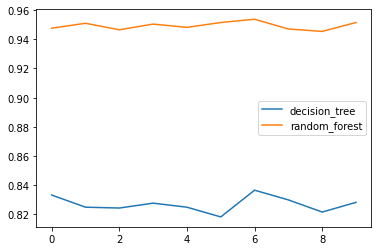

In [12]:
df.plot()
plt.show()

최종 정확도

In [15]:
print('의사 결정 트리: {:.3%}'.format(np.mean(dt_cv_scores)))
print('랜덤 포레스트: {:.3%}'.format(np.mean(rf_cv_scores)))

의사 결정 트리: 82.674%
랜덤 포레스트: 94.935%
